### Exploring the persistence of age-related trends

In [1]:
%matplotlib inline
from astropy import stats
from statsmodels.robust.norms import TukeyBiweight
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression
from scipy.stats import skew, skewtest, truncnorm
import sys
import warnings
warnings.filterwarnings("ignore")
sys.path.append('../../lib/')
from regimeshifts import ews

In [2]:
%load_ext rpy2.ipython

In [3]:
ice_shells = pd.read_csv('output/raw_ind_shells_ICE_PB.csv',index_col=0) ##Iceland
iom_shells = pd.read_csv('output/raw_ind_shells_IS_PB.csv',index_col=0)
iom_birth_year = pd.read_csv('../../../datasets/bivalve-sclerochronologies/Butler_Irish_Sea_2009/birth_year_ind_shells.csv',index_col=0)

In [4]:
### Obtaining the widest year
iom_starts = pd.DataFrame(index=iom_shells.columns,columns=['Start_year','Birth_year','Widest_year','n_widest','Widest11_year','n11_widest'])
for col in iom_shells.columns:
    iom_starts.loc[col,'Start_year'] = iom_shells[col].first_valid_index()
    iom_starts.loc[col,'Widest_year'] = iom_shells[col].idxmax()
    iom_starts.loc[col,'Widest11_year'] = iom_shells[col].dropna().iloc[0:11].idxmax()
iom_starts['n_widest'] = iom_starts['Widest_year'] - iom_starts['Start_year']
iom_starts['n11_widest'] = iom_starts['Widest11_year'] - iom_starts['Start_year']
    
#    shell_number = int(col.strip('M').strip('L').strip('R').lstrip('0'))    
#    if shell_number in iom_birth_year.index:
#        iom_starts.loc[col,'Birth_year'] = iom_birth_year.loc[shell_number,'Sclero year of birth ']
#iom_starts['Age_start'] = iom_starts['Start_year'] - iom_starts['Birth_year']

#### Iceland
ice_starts = pd.DataFrame(index=ice_shells.columns,columns=['Start_year','Birth_year','Widest_year','n_widest','Widest11_year','n11_widest'])
for col in ice_shells.columns:
    ice_starts.loc[col,'Start_year'] = ice_shells[col].first_valid_index()
    ice_starts.loc[col,'Widest_year'] = ice_shells[col].idxmax()
    ice_starts.loc[col,'Widest11_year'] = ice_shells[col].dropna().iloc[0:11].idxmax()
ice_starts['n_widest'] = ice_starts['Widest_year'] - ice_starts['Start_year']
ice_starts['n11_widest'] = ice_starts['Widest11_year'] - ice_starts['Start_year']

In [5]:
### Counting the shells with different label codes
key_count = {}
for col in iom_shells.columns:
    nchar = 2 if len(col)==9 else 1   
    if col[-nchar:] in key_count.keys():
        key_count[col[-nchar:]] += 1
    else:
        key_count[col[-nchar:]] = 1

#### Removing the increment widths before the widest increment dound within the first 11 years

In [6]:
def remove_earliest(series,firstnyears=11):
    cropped_series = series.copy()
    widest_year = series.dropna().iloc[0:firstnyears].idxmax()
    cropped_series[cropped_series.index < widest_year] = np.nan
    return cropped_series

In [8]:
ice_shells_cr = ice_shells.apply(remove_earliest,axis=0)
iom_shells_cr = iom_shells.apply(remove_earliest,axis=0)

#### Negative exponential method

In [9]:
%%R -i ice_shells_cr -i iom_shells_cr -o NE_ice -o NE_iom
library(dplR)
NE_ice <- detrend(rwl = ice_shells_cr, method = "ModNegExp")
NE_iom <- detrend(rwl = iom_shells_cr, method = "ModNegExp")

R[write to console]: This is dplR version 1.7.7.
dplR is part of openDendro https://opendendro.org.
New users can visit https://opendendro.github.io/dplR-workshop/ to get started.



#### Power transformation

In [11]:
%%R -i ice_shells_cr -i iom_shells_cr -o PwT_ice -o PwT_iom
library(dplR)
PwT_ice <- powt(rwl = ice_shells_cr, rescale=TRUE)
PwT_iom <- powt(rwl = iom_shells_cr, rescale=TRUE)

#### Negative exponential + Power transformation

In [12]:
%%R -i PwT_ice -i PwT_iom -o NE_PT_ice -o NE_PT_iom
library(dplR)
NE_PT_ice <- detrend(rwl = PwT_ice, method = "ModNegExp", difference=TRUE)
NE_PT_iom <- detrend(rwl = PwT_iom, method = "ModNegExp", difference=TRUE)

### Smoothing splines

In [13]:
iom_fr_cutoff = int(iom_shells_cr.count().mean() * 0.67)
ice_fr_cutoff = int(ice_shells_cr.count().mean() * 0.67)

In [14]:
%%R -i ice_shells_cr -i iom_shells_cr -i iom_fr_cutoff -i ice_fr_cutoff --o Spl67p_ice -o Spl67p_iom
library(dplR)
Spl67p_ice <- detrend(rwl = ice_shells_cr,f=0.5, method = "Spline")
Spl67p_iom<- detrend(rwl = iom_shells_cr,f=0.5, method = "Spline")

In [15]:
%%R -i PwT_ice -i PwT_iom -o Spl67p_PT_ice -o Spl67p_PT_iom
library(dplR)
Spl67p_PT_ice <- detrend(rwl = PwT_ice,f=0.5, method = "Spline", difference=TRUE)
Spl67p_PT_iom<- detrend(rwl = PwT_iom,f=0.5, method = "Spline", difference=TRUE)

In [16]:
%%R -i ice_shells_cr -i iom_shells_cr -o Spl30_ice -o Spl30_iom
library(dplR)
Spl30_ice <- detrend(rwl = ice_shells_cr,f=0.5,nyrs=30, method = "Spline")
Spl30_iom<- detrend(rwl = iom_shells_cr,f=0.5,nyrs=30, method = "Spline")

In [17]:
%%R -i ice_shells_cr -i iom_shells_cr -o Spl45_ice -o Spl45_iom
library(dplR)
Spl45_ice <- detrend(rwl = ice_shells_cr,f=0.5,nyrs=45, method = "Spline")
Spl45_iom<- detrend(rwl = iom_shells_cr,f=0.5,nyrs=45, method = "Spline")

In [18]:
%%R -i ice_shells_cr -i iom_shells_cr -o Spl45_ice -o Spl45_iom -o Spl80_ice -o Spl80_iom
library(dplR)
Spl45_ice <- detrend(rwl = ice_shells_cr,f=0.5,nyrs=45, method = "Spline")
Spl45_iom<- detrend(rwl = iom_shells_cr,f=0.5,nyrs=45, method = "Spline")
### 80 year cutoff
Spl80_ice <- detrend(rwl = ice_shells_cr,f=0.5,nyrs=80, method = "Spline")
Spl80_iom<- detrend(rwl = iom_shells_cr,f=0.5,nyrs=80, method = "Spline")

### Regional Curve Standardisation

In [19]:
#Selecting only measurements on the hinge plate (discarding margin selection)
iom_hinge = [sh for sh in iom_shells.columns if 'LM' not in sh and 'RM' not in sh]

In [20]:
iom_sh_hinge = iom_shells_cr[iom_hinge]
### Pitch offset 
iom_po = (iom_sh_hinge.count() - iom_sh_hinge.count()+1).to_frame().reset_index().rename(columns={0:'pith.offset','index':'series'})

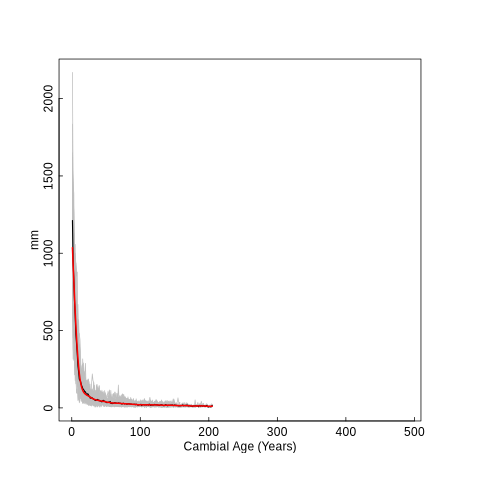

In [21]:
%%R -i iom_sh_hinge -i iom_po -o RCS_iom
library(dplR)
RCS_iom <- rcs(rwl = iom_sh_hinge,po=iom_po)

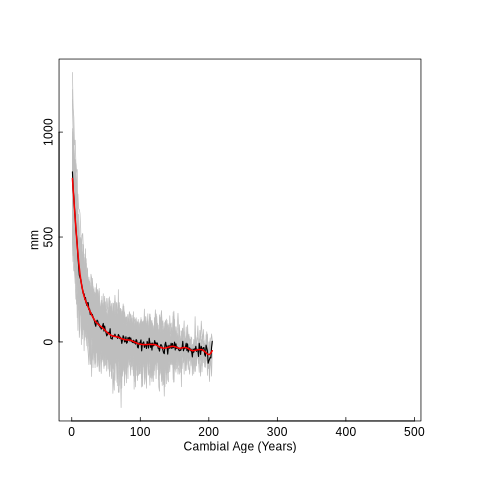

In [22]:
%%R -i iom_sh_hinge -i iom_po -o RCS_PT_iom
library(dplR)
PwT_iom <- powt(rwl = iom_sh_hinge, rescale=TRUE)
RCS_PT_iom <- rcs(rwl = PwT_iom,po=iom_po,ratios=FALSE)

## Results

In [23]:
detr_series = {'NE_ratios' : {'Ice':NE_ice,'IoM':NE_iom},
               'NE_PT': {'Ice':NE_PT_ice,'IoM':NE_PT_iom},
               'SP67p_ratios': {'Ice':Spl67p_ice,'IoM':Spl67p_iom},
               'SP67p_PT': {'Ice':Spl67p_PT_ice,'IoM':Spl67p_PT_iom},
               'RCS_ratios': {'Ice':None,'IoM':RCS_iom},
               'RCS_PT': {'Ice':None,'IoM':RCS_PT_iom},
                }

In [24]:
sgi = {}
for detrMeth, shells_all in detr_series.items():
    shells_ls = []
    for loc,sh_rec in shells_all.items():
        if sh_rec is not None:
            for shell in sh_rec.columns:
                ts = sh_rec[shell].dropna().reset_index(drop=True)
                ts_std = (ts - ts.mean())/ ts.std()
                shells_ls.append(ts_std)
    sgi[detrMeth] = pd.concat(shells_ls, axis=1, sort=False)

In [25]:
titles = {'NE_ratios': 'Negative Exponential (Ratios)',
          'NE_PT':'Negative Exponential (PT)',
          'SP67p_ratios': 'Smoothing Splines (Ratios)',
          'SP67p_PT': 'Smoothing Splines (PT)',
          'RCS_ratios':'Regional Curve Standardisation (Ratios)',
          'RCS_PT':'Regional Curve Standardisation (PT)'}

In [26]:
### AR(1) and variance on each record
wL = 45
resar1_indshells = {'Ice':{},'IoM':{}}
stdar1_indshells = {'Ice':{},'IoM':{}}
stdvar_indshells = {'Ice':{},'IoM':{}}
for loc in ['Ice', 'IoM']:
    for i,(detrM,detrM_dict) in enumerate(detr_series.items()):
        sgi_detrM = detrM_dict[loc]
        if sgi_detrM is not None:
            sgi_l = sgi_detrM[sgi_detrM.count()[sgi_detrM.count()>wL+12].index]
            sgi_l.index = sgi_l.index.astype(int)
            ## Resilience metrics
            ar1_ind_sh = ews.Ews(sgi_l).ar1(wL=wL)
            var_ind_sh = ews.Ews(sgi_l).var(wL=wL)
            ar1_ind_sh = ar1_ind_sh[ar1_ind_sh.index>=1850]
            var_ind_sh = var_ind_sh[var_ind_sh.index>=1850]
            std_var_ind = (var_ind_sh - var_ind_sh.mean())/var_ind_sh.std()
            res_ar1_ind = ar1_ind_sh - ar1_ind_sh.mean()   
            std_ar1_ind = (ar1_ind_sh - ar1_ind_sh.mean())/ar1_ind_sh.std()
            resar1_indshells[loc][detrM] = res_ar1_ind
            stdar1_indshells[loc][detrM] = std_ar1_ind
            stdvar_indshells[loc][detrM] = std_var_ind

In [27]:
def get_rbar(df,wL=50,method='pearson',min_obs=10):
    """
    Gets the mean interseries correlation between all series
    """
    time = df.index.values
    rbar = pd.Series(index=time)
    for t in np.arange(time[0],time[-wL]):
        corrs = df.loc[t:t+wL].corr(method=method,min_periods=min_obs)
        #corrs = corrs.replace({1: np.nan}) 
        ## Removes the diagonal of the correlation matrix
        np.fill_diagonal(corrs.values, np.nan)
        ## JUst preserving the uuper triangle of the correlation matrix
        corrs = corrs.where(np.triu(np.ones(corrs.shape)).astype(bool))
        #corrs_arr = corrs.to_numpy().flatten() #np.nanmean(corrs_arr)
        rbar.loc[t+wL] = corrs.mean().mean() ### Gets the mean correlation
    return rbar
def get_eps(df,wL=50,min_obs=10):
    """
    Estimates the Expressed Population Signal using the average number of individuals per year
    """
    time = df.index.values
    rbar = pd.Series(index=time)
    eps = pd.Series(index=time)
    for t in np.arange(time[0],time[-wL]):
        roll_df = df.loc[t:t+wL]
        corrs = roll_df.corr(min_periods=min_obs)
        np.fill_diagonal(corrs.values, np.nan)
        ## JUst preserving the uuper triangle of the correlation matrix
        corrs = corrs.where(np.triu(np.ones(corrs.shape)).astype(bool))
        rbar = corrs.mean().mean()
        ### obtaining the average number of trees for each year
        #N = len(roll_df.count()[roll_df.count()>=min_obs])
        N = np.round(roll_df.count(axis=1).mean(),0)
        eps.loc[t+wL] = (N * np.abs(rbar)) / (((N-1)*np.abs(rbar))+1)
    return eps

In [28]:
min_obs = 1
rbar_stats = {}
for loc in ['Ice', 'IoM']:
    stats_rbar = pd.DataFrame(index=list(resar1_indshells[loc].keys()),
                                columns=['avgrbar_ar1','avgrbar_var','avgeps_ar1','avgeps_var'])
    wL = 35
    for method in resar1_indshells[loc].keys():
        ar1_df = resar1_indshells[loc][method]
        var_df = stdvar_indshells[loc][method]
        ar1_df =  ar1_df[ar1_df.index>=1870]
        var_df = var_df[var_df.index>=1870]
        if loc == 'Ice':
            ar1_df =  ar1_df[ar1_df.index>=1940]
            var_df = var_df[var_df.index>=1940]
            wL = 5
        rbar_ar1 = get_rbar(ar1_df,wL=wL,min_obs=min_obs)
        rbar_var = get_rbar(var_df,wL=wL,min_obs=min_obs)
        eps_ar1 = get_eps(ar1_df,wL=wL,min_obs=min_obs)
        eps_var = get_eps(var_df,wL=wL,min_obs=min_obs)
        #std_ar1 = ((ar1_df-ar1_df.mean())/ar1_df.std()).std(1).rolling(5).mean()
        #std_var = ((var_df-var_df.mean())/var_df.std()).std(1).rolling(5).mean()
        stats_rbar.loc[method,'avgrbar_ar1'] = rbar_ar1.mean()
        stats_rbar.loc[method,'avgrbar_var'] = rbar_var.mean()
        stats_rbar.loc[method,'medrbar_ar1'] = rbar_ar1.median()
        stats_rbar.loc[method,'medrbar_var'] = rbar_var.median()
        stats_rbar.loc[method,'minrbar_ar1'] = rbar_ar1.quantile(0.25)
        stats_rbar.loc[method,'minrbar_var'] = rbar_var.quantile(0.25)
        stats_rbar.loc[method,'maxrbar_ar1'] = rbar_ar1.quantile(0.75)
        stats_rbar.loc[method,'maxrbar_var'] = rbar_var.quantile(0.75)
        stats_rbar.loc[method,'avgeps_ar1'] = eps_ar1.mean()
        stats_rbar.loc[method,'avgeps_var'] = eps_var.mean()
    rbar_stats[loc] = stats_rbar

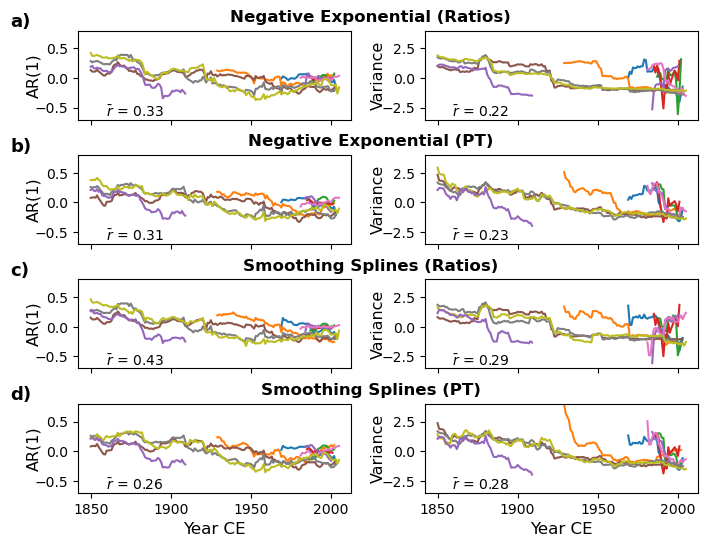

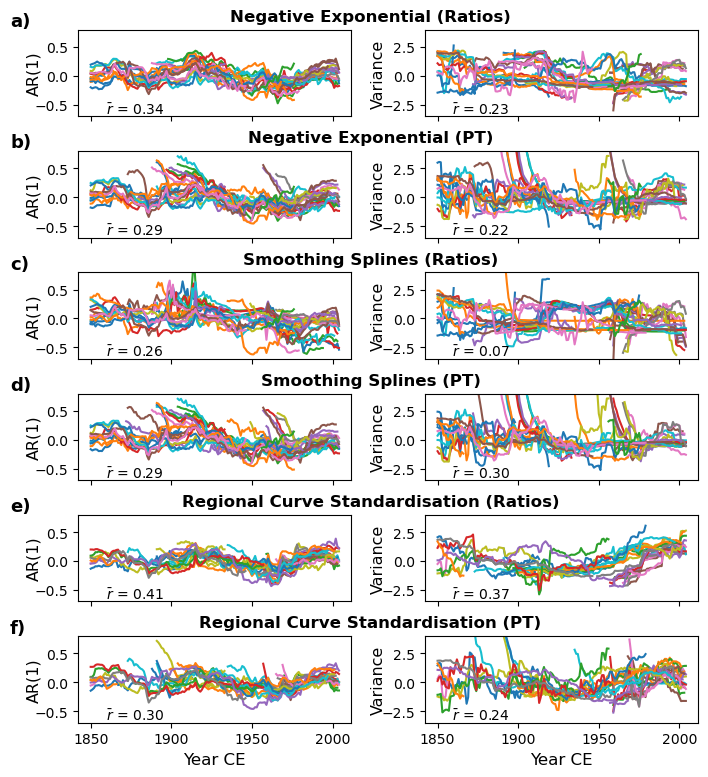

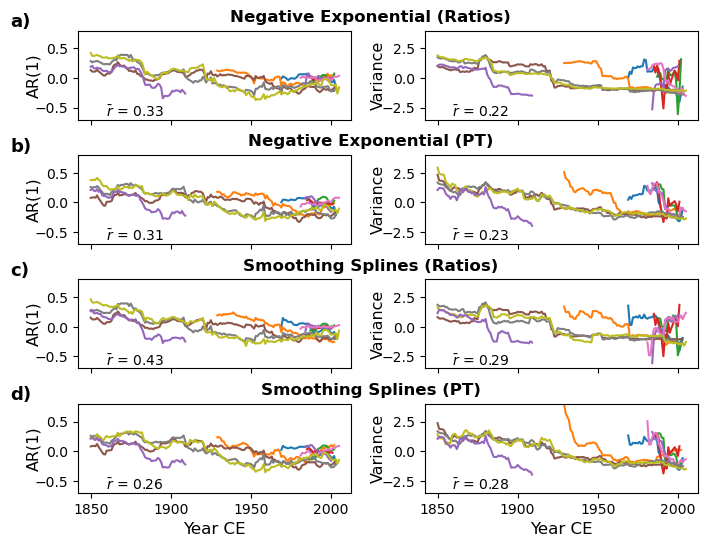

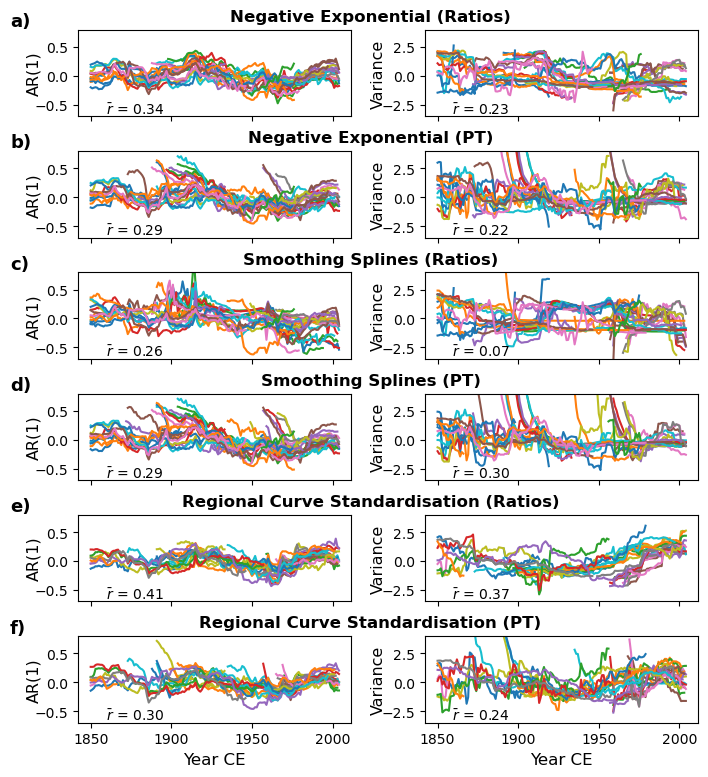

In [31]:
letters = {0: 'a)', 1: 'b)', 2:'c)', 3:'d)',4:'e)',5:'f)',6:'g)'}
locs = {'Ice':4, 'IoM':6}
for loc,nmeth in locs.items():
    plt.close()
    fig, axs = plt.subplots(nmeth,2,figsize=(8,1.5*(nmeth)),sharex='col',facecolor='white',
                            gridspec_kw={'wspace': 0.27,'hspace':0.4}) # 
    ###
    for i,detrMeth in enumerate(resar1_indshells[loc].keys()):
        resar1_indshells[loc][detrMeth].plot(ax=axs[i,0],legend=False)
        stdvar_indshells[loc][detrMeth].plot(ax=axs[i,1],legend=False)
        avgrb_ar1 = rbar_stats[loc].loc[detrMeth,'avgrbar_ar1']
        avgrb_var = rbar_stats[loc].loc[detrMeth,'avgrbar_var']
        axs[i,0].text(0.1,0.03,r'$\bar{r}$'+f' = {avgrb_ar1:.2f}',transform=axs[i,0].transAxes)
        axs[i,1].text(0.1,0.03,r'$\bar{r}$'+f' = {avgrb_var:.2f}',transform=axs[i,1].transAxes)
        
        axs[i,0].text(1.07,1.1,titles[detrMeth],transform=axs[i,0].transAxes,horizontalalignment='center',fontsize=12, weight='bold')
        axs[i,0].text(-0.25,1.04,letters[i],transform=axs[i,0].transAxes,fontsize=13, weight='bold')
        axs[i,0].set_ylabel('AR(1)',fontsize=11.5,labelpad=-5);
        axs[i,1].set_ylabel('Variance',fontsize=11.5,labelpad=-3);
        axs[i,0].set_ylim(-0.7,0.8)
        axs[i,1].set_ylim(-3.5,4)
    axs[-1,0].set_xlabel('Year CE',fontsize=12)
    axs[-1,1].set_xlabel('Year CE',fontsize=12)
    fig.savefig(f'img/detr_tech_ind_shells_{loc}.jpg',dpi=300, bbox_inches='tight')
    plt.show()

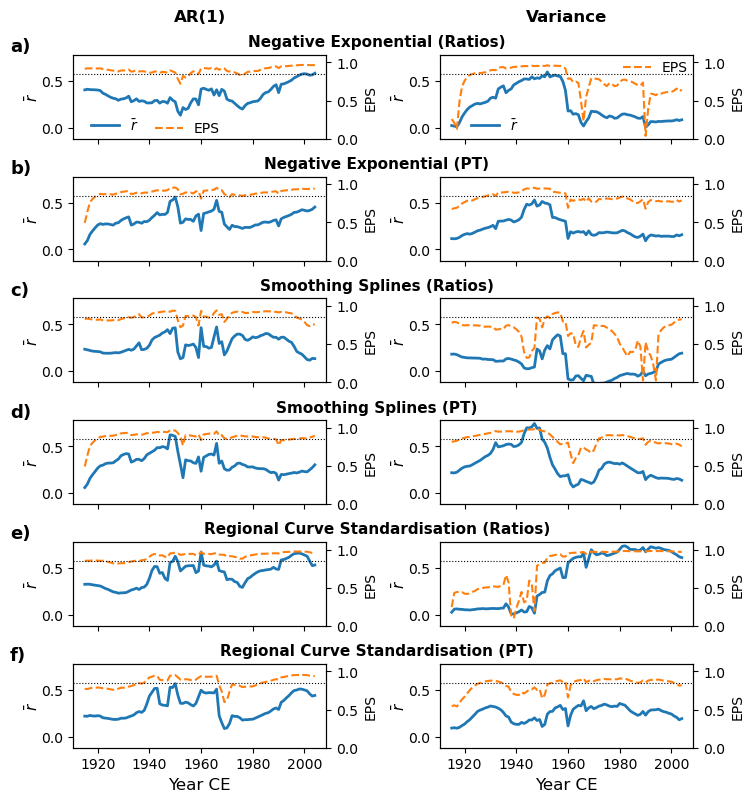

In [32]:
wL = 35
locs = {'IoM':6}#,'Ice':4}
for loc,nmeth in locs.items():
    plt.close()
    fig, axs = plt.subplots(nmeth,2,figsize=(8,1.5*(nmeth)),sharex='col',
                            facecolor='white',gridspec_kw={'wspace': 0.45,'hspace':0.45}) # 
    for i,detrMeth in enumerate(resar1_indshells[loc].keys()):
        ar1_df = resar1_indshells[loc][detrMeth]
        var_df = stdvar_indshells[loc][detrMeth]
        ar1_df = ar1_df[ar1_df.index>=1880]
        var_df = var_df[var_df.index>=1880]
        ## Statistics
        rbar_ar1 = get_rbar(ar1_df,wL=wL,min_obs=1)
        rbar_var = get_rbar(var_df,wL=wL,min_obs=1)
        eps_ar1 = get_eps(ar1_df,wL=wL,min_obs=1)
        eps_var = get_eps(var_df,wL=wL,min_obs=1)

        rbar_ar1.plot(ax=axs[i,0],legend=False,color='tab:blue',linewidth=2)
        rbar_var.plot(ax=axs[i,1],legend=False,color='tab:blue',linewidth=2)
        axleft = axs[i,0].twinx()
        #axleft_std = axs[i,0].twinx()
        axright = axs[i,1].twinx()
        #axright_std = axs[i,1].twinx()
        eps_ar1.plot(ax=axleft,legend=False,color='tab:orange',linestyle='--')
        eps_var.plot(ax=axright,legend=False,color='tab:orange',linestyle='--')
        axleft.axhline(0.85,linestyle=':',color='k',linewidth=0.8)
        axright.axhline(0.85,linestyle=':',color='k',linewidth=0.8)
        
        
        if i == 0:
            axs[0,0].legend([r'$\bar{r}$'],frameon=False,loc=(0.05,0))
            axs[0,1].legend([r'$\bar{r}$'],frameon=False,loc=(0.1,0))
            axleft.legend([r'EPS'],frameon=False,loc=(0.3,-0.03))
            axright.legend([r'EPS'],frameon=False,loc=(0.7,0.7))
            #axs[i,0].text(1.2,1.3,titles[detrMeth],transform=axs[i,0].transAxes,horizontalalignment='center',fontsize=12, weight='bold')
            axs[i,0].set_title('AR(1)',y=1.3, weight='bold',fontsize=12)
            axs[i,1].set_title('Variance',y=1.3, weight='bold',fontsize=12)
        
        axs[i,0].text(1.2,1.1,titles[detrMeth],transform=axs[i,0].transAxes,horizontalalignment='center',fontsize=11, weight='bold')
        axs[i,0].text(-0.25,1.04,letters[i],transform=axs[i,0].transAxes,fontsize=13, weight='bold')
        axs[i,0].set_ylabel(r'$\bar{r}$',fontsize=11,labelpad=0);
        axs[i,1].set_ylabel(r'$\bar{r}$',fontsize=11,labelpad=0);
        axleft.set_ylabel('EPS',fontsize=10);
        axright.set_ylabel(r'EPS',fontsize=10);
        axleft.set_ylim(0,1.1)
        axright.set_ylim(0,1.1)
        #axleft_std.set_ylim(0.07,0.22)
        #axright_std.set_ylim(0.5,1.3)
        axs[i,0].set_ylim(-0.12,0.78)
        axs[i,1].set_ylim(-0.12,0.78)
    axs[-1,0].set_xlabel('Year CE',fontsize=12)
    axs[-1,1].set_xlabel('Year CE',fontsize=12)
    fig.savefig(f'img/detr_tech_Rbar_EPS_{loc}.jpg',dpi=300, bbox_inches='tight')
    plt.show()

### Trends distribution

In [33]:
sgi2 = {}
for detrMeth, shells_all in detr_series.items():
    shells_ls = []
    for loc,sh_rec in shells_all.items():
        if sh_rec is not None and loc != 'FG':
            for shell in sh_rec.columns:
                ts = sh_rec[shell].dropna().reset_index(drop=True)
                ts_std = (ts - ts.mean())/ ts.std()
                shells_ls.append(ts_std)
    sgi2[detrMeth] = pd.concat(shells_ls, axis=1, sort=False)

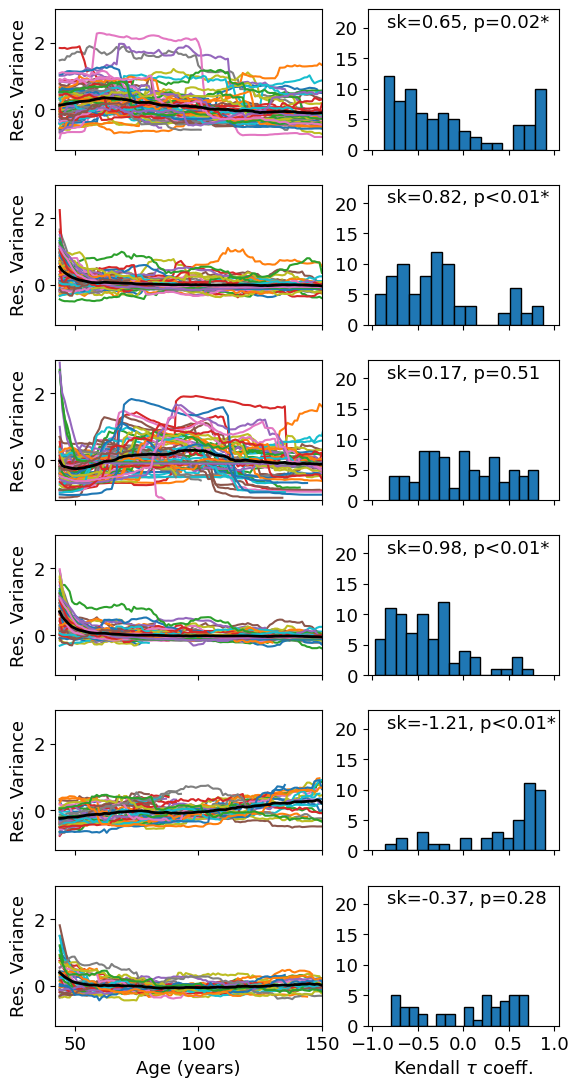

In [34]:
wL = 45 ## Window length
#wL= 0.5
age_meas = 150
age_limit = 150
min_n = 15 ## Minimum number of data points needed to measure the trend in the resilience indicator
plt.close()
fig, axs = plt.subplots(len(sgi2),2,figsize=(6.5,2.2*len(sgi2)),sharex='col',
                        gridspec_kw={'width_ratios':[1.4,1],'hspace': 0.25})
for i,(detrMeth, sgi_detr) in enumerate(sgi2.items()):
    count_dataP = sgi2[detrMeth].count()
    long_shells = sgi2[detrMeth][count_dataP[count_dataP>=wL+min_n].index.values]
    var_roll = ews.Ews(long_shells).var(wL=wL)
    var_roll_res = var_roll - var_roll.mean()
    #var_roll = var_roll[var_roll.index<=age_limit]
    kc_var = var_roll[var_roll.index<=age_meas].kendall.dropna().values
    #kc_var = var_roll.kendall.dropna().values
    var_roll_res.plot(legend=False, ax=axs[i,0])
    var_roll_res.mean(axis=1).plot(ax=axs[i,0],color='k',linewidth=2)
    pval = skewtest(kc_var).pvalue
    psig = '*' if pval<0.05 else ''
    comp = '<' if pval< 0.01 else '='
    pval = 0.01 if pval<0.01 else pval
    label = f'sk={skew(kc_var):.2f}, p{comp}{pval:.2f}{psig}'
    axs[i,1].hist(kc_var,edgecolor = "black",bins=15)
    #axs[i,1].legend(frameon=False, fontsize="13")    
    axs[i,1].text(0.1,0.87,label,transform=axs[i,1].transAxes,fontsize=13)
    axs[i,1].set_xlim(-1.05,1.05)
    axs[i,0].set_ylim(-1.2,3)
    axs[i,1].set_xticks([-1,-0.5,0,0.5,1])
    axs[i,1].yaxis.set_major_locator(MaxNLocator(integer=True))
    axs[i,1].set_yticks([0,5,10,15,20])
    axs[i,0].set_xlim(wL-3,age_limit)
    axs[i,1].set_ylim(0,23)
    axs[i,1].tick_params(axis='both', which='major', labelsize=13)
    axs[i,0].tick_params(axis='both', which='major', labelsize=13)
    #axs[i,0].text(1.07,1.08,titles[detrMeth],transform=axs[i,0].transAxes,horizontalalignment='center',fontsize=12, weight='bold')
    #axs[i,0].text(-0.12,1.08,letters[i],transform=axs[i,0].transAxes,fontsize=13, weight='bold')
    axs[i,0].set_ylabel('Res. Variance',fontsize=13);
axs[-1,0].set_xlabel('Age (years)',fontsize=13)
axs[-1,1].set_xlabel(r'Kendall $\tau$ coeff.',fontsize=13);
fig.savefig(f'img/detr_tech_effect_variance_wL{wL}.png',dpi=300, bbox_inches='tight')
plt.show()

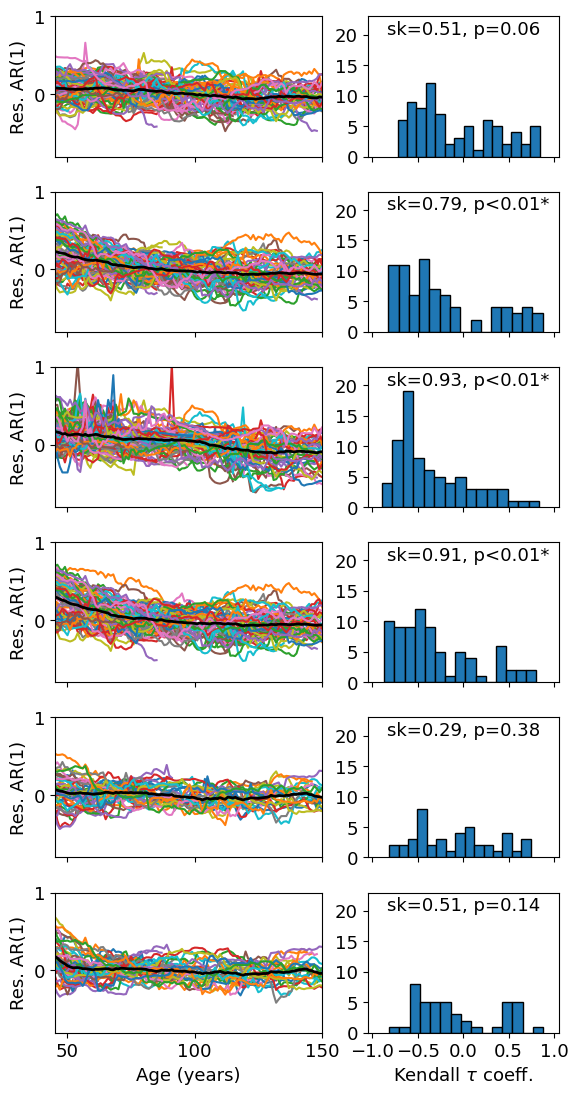

In [35]:
wL = 45 ## Window length
#wL= 0.5
age_meas = 150
age_limit = 150
min_n = 15 ## Minimum number of data points needed to measure the trend in the resilience indicator
plt.close()
fig, axs = plt.subplots(len(sgi2),2,figsize=(6.5,2.2*len(sgi2)),sharex='col',
                        gridspec_kw={'width_ratios':[1.4,1],'hspace': 0.25})
for i,(detrMeth, sgi_detr) in enumerate(sgi2.items()):
    count_dataP = sgi2[detrMeth].count()
    long_shells = sgi2[detrMeth][count_dataP[count_dataP>=wL+min_n].index.values]
    ar1_roll = ews.Ews(long_shells).ar1(wL=wL)
    ar1_roll_res = ar1_roll - ar1_roll.mean() ## Getting the residuals
        #ar1_roll = ar1_roll[ar1_roll.index<=age_limit]
    kc_ar1 = ar1_roll[ar1_roll.index<=age_meas].kendall.dropna().values
    #kc_ar1 = ar1_roll.kendall.dropna().values
    ar1_roll_res.plot(legend=False, ax=axs[i,0])
    ar1_roll_res.mean(axis=1).plot(ax=axs[i,0],color='k',linewidth=2)
    pval = skewtest(kc_ar1).pvalue
    psig = '*' if pval<0.05 else ''
    comp = '<' if pval< 0.01 else '='
    pval = 0.01 if pval<0.01 else pval
    label = f'sk={skew(kc_ar1):.2f}, p{comp}{pval:.2f}{psig}'
    xpos, ypos = 0.1, 0.87
    axs[i,1].hist(kc_ar1,edgecolor = "black",bins=15)
    #axs[i,1].legend(frameon=False)
    axs[i,1].text(xpos,ypos,label,transform=axs[i,1].transAxes,fontsize=13)
    axs[i,1].set_xlim(-1.05,1.05)
    axs[i,0].set_ylim(-0.8,1)
    axs[i,1].set_xticks([-1,-0.5,0,0.5,1])
    axs[i,1].yaxis.set_major_locator(MaxNLocator(integer=True))
    axs[i,1].set_yticks([0,5,10,15,20])
    axs[i,1].set_ylim(0,23)
    axs[i,0].set_xlim(wL,age_limit)
    axs[i,1].tick_params(axis='both', which='major', labelsize=13)
    axs[i,0].tick_params(axis='both', which='major', labelsize=13)
    #axs[i,0].text(1.07,1.08,titles[detrMeth],transform=axs[i,0].transAxes,horizontalalignment='center',fontsize=12, weight='bold')
    #axs[i,0].text(-0.12,1.08,letters[i],transform=axs[i,0].transAxes,fontsize=13, weight='bold')
    axs[i,0].set_ylabel('Res. AR(1)',fontsize=13);
axs[-1,0].set_xlabel('Age (years)',fontsize=13)
axs[-1,1].set_xlabel(r'Kendall $\tau$ coeff.',fontsize=13);
#fig.savefig(f'img/detr_tech_effect_ar1_wL{wL}.png',dpi=300, bbox_inches='tight')
plt.show()

#### Smoothing splines

In [36]:
detr_spl = {'SP30_ratios': {'Ice':Spl30_ice,'IoM':Spl30_iom},
               'SP45_ratios': {'Ice':Spl45_ice,'IoM':Spl45_iom},
               'SP80_ratios': {'Ice':Spl80_ice,'IoM':Spl80_iom},
                }

In [37]:
sgi_spl = {}
for detrMeth, shells_all in detr_spl.items():
    shells_ls = []
    for loc,sh_rec in shells_all.items():
        if sh_rec is not None:
            for shell in sh_rec.columns:
                ts = sh_rec[shell].dropna().reset_index(drop=True)
                ts_std = (ts - ts.mean())/ ts.std()
                shells_ls.append(ts_std)
    sgi_spl[detrMeth] = pd.concat(shells_ls, axis=1, sort=False)

In [38]:
titles_spl = {'SP30_ratios': 'SP30',
              'SP45_ratios':'SP45',
              'SP80_ratios': 'SP80'}

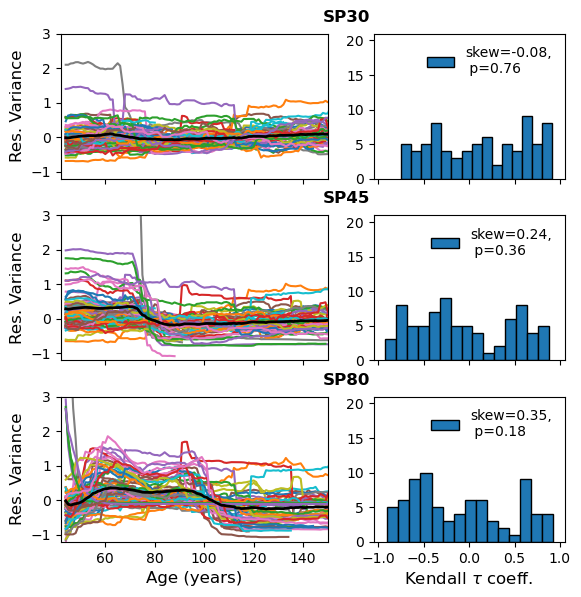

In [41]:
wL = 45 ## Window length
#wL= 0.5
age_meas = 150
age_limit = 150
min_n = 15 ## Minimum number of data points needed to measure the trend in the resilience indicator
plt.close()
fig, axs = plt.subplots(len(sgi_spl),2,figsize=(6.5,2.2*len(sgi_spl)),sharex='col',
                        gridspec_kw={'width_ratios':[1.4,1],'hspace': 0.25})
for i,(detrMeth, sgi_detr) in enumerate(sgi_spl.items()):
    count_dataP = sgi_spl[detrMeth].count()
    long_shells = sgi_spl[detrMeth][count_dataP[count_dataP>=wL+min_n].index.values]
    var_roll = ews.Ews(long_shells).var(wL=wL)
    var_roll_res = var_roll - var_roll.mean()
    #var_roll = var_roll[var_roll.index<=age_limit]
    kc_var = var_roll[var_roll.index<=age_meas].kendall.dropna().values
    #kc_var = var_roll.kendall.dropna().values
    var_roll_res.plot(legend=False, ax=axs[i,0])
    var_roll_res.mean(axis=1).plot(ax=axs[i,0],color='k',linewidth=2)
    pval = skewtest(kc_var).pvalue
    psig = '*' if pval<0.05 else ''
    comp = '<' if pval< 0.01 else '='
    pval = 0.01 if pval<0.01 else pval
    axs[i,1].hist(kc_var,label=f'skew={skew(kc_var):.2f},\n p{comp}{pval:.2f}{psig}',edgecolor = "black",bins=15)
    axs[i,1].legend(frameon=False)    
    axs[i,1].set_xlim(-1.05,1.05)
    axs[i,0].set_ylim(-1.2,3)
    axs[i,1].set_xticks([-1,-0.5,0,0.5,1])
    axs[i,1].yaxis.set_major_locator(MaxNLocator(integer=True))
    axs[i,1].set_yticks([0,5,10,15,20])
    axs[i,0].set_xlim(wL-3,age_limit)
    axs[i,1].set_ylim(0,21)
    axs[i,0].text(1.07,1.08,titles_spl[detrMeth],transform=axs[i,0].transAxes,horizontalalignment='center',fontsize=12, weight='bold')
    #axs[i,0].text(-0.12,1.08,letters[i],transform=axs[i,0].transAxes,fontsize=13, weight='bold')
    axs[i,0].set_ylabel('Res. Variance',fontsize=12);
axs[-1,0].set_xlabel('Age (years)',fontsize=12)
axs[-1,1].set_xlabel(r'Kendall $\tau$ coeff.',fontsize=12);
fig.savefig(f'img/detr_tech_effect_variance_spl_wL{wL}.png',dpi=300, bbox_inches='tight')
plt.show()

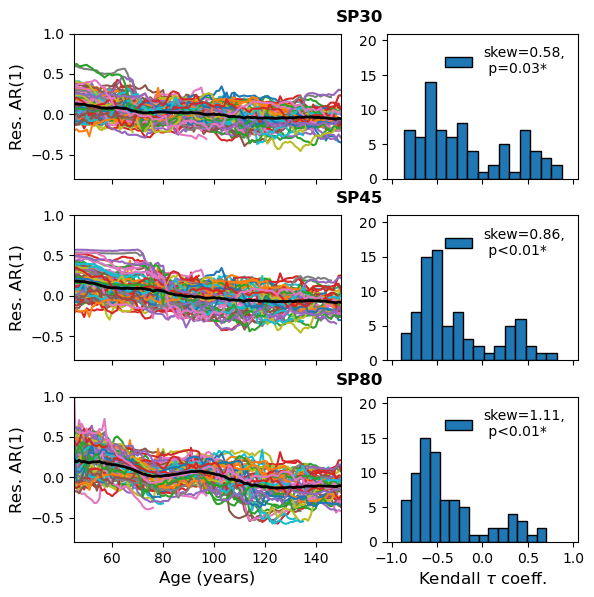

In [40]:
wL = 45 ## Window length
#wL= 0.5
age_meas = 160
age_limit = 150
min_n = 15 ## Minimum number of data points needed to measure the trend in the resilience indicator
plt.close()
fig, axs = plt.subplots(len(sgi_spl),2,figsize=(6.5,2.2*len(sgi_spl)),sharex='col',
                        gridspec_kw={'width_ratios':[1.4,1],'hspace': 0.25})
for i,(detrMeth, sgi_detr) in enumerate(sgi_spl.items()):
    count_dataP = sgi_spl[detrMeth].count()
    long_shells = sgi_spl[detrMeth][count_dataP[count_dataP>=wL+min_n].index.values]
    ar1_roll = ews.Ews(long_shells).ar1(wL=wL)
    ar1_roll_res = ar1_roll - ar1_roll.mean() ## Getting the residuals
        #ar1_roll = ar1_roll[ar1_roll.index<=age_limit]
    kc_ar1 = ar1_roll[ar1_roll.index<=age_meas].kendall.dropna().values
    #kc_ar1 = ar1_roll.kendall.dropna().values
    ar1_roll_res.plot(legend=False, ax=axs[i,0])
    ar1_roll_res.mean(axis=1).plot(ax=axs[i,0],color='k',linewidth=2)
    pval = skewtest(kc_ar1).pvalue
    psig = '*' if pval<0.05 else ''
    comp = '<' if pval< 0.01 else '='
    pval = 0.01 if pval<0.01 else pval
    axs[i,1].hist(kc_ar1,label=f'skew={skew(kc_ar1):.2f},\n p{comp}{pval:.2f}{psig}',edgecolor = "black",bins=15)
    axs[i,1].legend(frameon=False)
    axs[i,1].set_xlim(-1.05,1.05)
    axs[i,0].set_ylim(-0.8,1)
    axs[i,1].set_xticks([-1,-0.5,0,0.5,1])
    axs[i,1].yaxis.set_major_locator(MaxNLocator(integer=True))
    axs[i,1].set_yticks([0,5,10,15,20])
    axs[i,1].set_ylim(0,21)
    axs[i,0].set_xlim(wL,age_limit)
    axs[i,0].text(1.07,1.08,titles_spl[detrMeth],transform=axs[i,0].transAxes,horizontalalignment='center',fontsize=12, weight='bold')
    #axs[i,0].text(-0.12,1.08,letters[i],transform=axs[i,0].transAxes,fontsize=13, weight='bold')
    axs[i,0].set_ylabel('Res. AR(1)',fontsize=12);
axs[-1,0].set_xlabel('Age (years)',fontsize=12)
axs[-1,1].set_xlabel(r'Kendall $\tau$ coeff.',fontsize=12);
fig.savefig(f'img/detr_tech_effect_ar1_spl_wL{wL}.png',dpi=300, bbox_inches='tight')
plt.show()